## EXERCISES


1. Fit <font size="4">  $y = A + B \frac{x}{\log_{10} x}$ </font>  for $\pi(x)$ by taking data of $\pi(x)$ for $x = 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000$. Predict $\pi(10^{10})$ using the model.

<br><br>

2. Fit <font size="5">  $y = \frac{x}{A \log x + B}$ </font> for $\pi(x)$ by taking data of $\pi(x)$ for $x = 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000$. Predict $\pi(10^{10})$ using the model.

<br><br>

3. Legendre (Mathematician, 1752 AD - 1833 AD; no computers during the period) gave $A = 1$, $B = -1.08366$ for the model <font size="5">  $y = \frac{x}{A \log x + B}$ </font>. 

Fit the model <font size="5">  $y = \frac{x}{A \log x + B}$ </font> with suitable data/techniques such that you get the values of $A$ and $B$ as close as possible to the values given by Legendre. Also, predict $\pi(10^{10})$ using your model.

## 1. Fit <font size="4">  $y = A + B \frac{x}{\log_{10} x}$ </font>  for $\pi(x)$ by taking data of $\pi(x)$ for $x = 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000$. Predict $\pi(10^{10})$ using the model.


In [37]:
import numpy as np, math


In [38]:
def sieve_bool_array(n: int) -> list[bool]:
    """Return a boolean list where True means prime, up to n."""
    if n < 2:
        return [False] * (n + 1)

    is_prime = [True] * (n + 1)
    is_prime[0] = is_prime[1] = False

    p = 2
    while p * p <= n:
        if is_prime[p]:
            for multiple in range(p * p, n + 1, p):
                is_prime[multiple] = False
        p += 1
    return is_prime


def prime_pi_data_range(start_x: int, end_x: int, step: int) -> tuple[list[int], list[int]]:
    """
    Generate (x_list, pi_list) where:
      x_list = [start_x, start_x+step, ..., end_x]
      pi_list = [pi(x) for x in x_list]

    Parameters:
        start_x (int): Starting x value (>= 1).
        end_x   (int): Ending x value.
        step    (int): Step size for x values.

    Returns:
        tuple[list[int], list[int]]
    """
    # Safety check
    if start_x < 1:
        start_x = 1
    if step <= 0:
        raise ValueError("Step size must be positive.")
    if end_x < start_x:
        return [], []

    # Step 1: Sieve up to end_x
    is_prime = sieve_bool_array(end_x)

    # Step 2: Precompute pi(x)
    pi = [0] * (end_x + 1)
    count = 0
    for i in range(1, end_x + 1):
        if is_prime[i]:
            count += 1
        pi[i] = count

    # Step 3: Build x_list and pi_list
    x_list = list(range(start_x, end_x + 1, step))
    pi_list = [pi[x] for x in x_list]

    return x_list, pi_list


In [39]:
x_list, pi_list = prime_pi_data_range(100,1000,100)
print("x_list:", x_list)
print("pi_list:", pi_list)        
x = np.array(x_list, dtype=float)
y = np.array(pi_list, dtype=float)
assert np.all(x>1) and np.all(y>0), 'Require x>1 and y>0'


x_list: [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
pi_list: [25, 46, 62, 78, 95, 109, 125, 139, 154, 168]


In [40]:
# Build regressor z = x/log x
z = x/np.log(x)
n = len(x)
Sz, Sy = z.sum(), y.sum()
Sz2 = (z*z).sum()
Szy = (z*y).sum()
Den = n*Sz2 - Sz*Sz
A1 = (Sy*Sz2 - Sz*Szy) / Den
B1 = (n*Szy - Sz*Sy) / Den
print(f'Model (i) parameters: A = {A1:.6f}, B = {B1:.6f}')
y_pred = A1 + B1*z
lse = ((y - y_pred)**2).sum()
print(f"Least squares error = {lse:.6f}")

Model (i) parameters: A = 1.217713, B = 1.154259
Least squares error = 4.694194


In [41]:
# Example prediction at x = 10^10
x_new = 10**10
z_new = x_new / np.log(x_new)
y_pred_new = A1 + B1 * z_new
print(f"Prediction: pi({x_new}) ≈ {y_pred_new:.2f}")

Prediction: pi(10000000000) ≈ 501288435.53


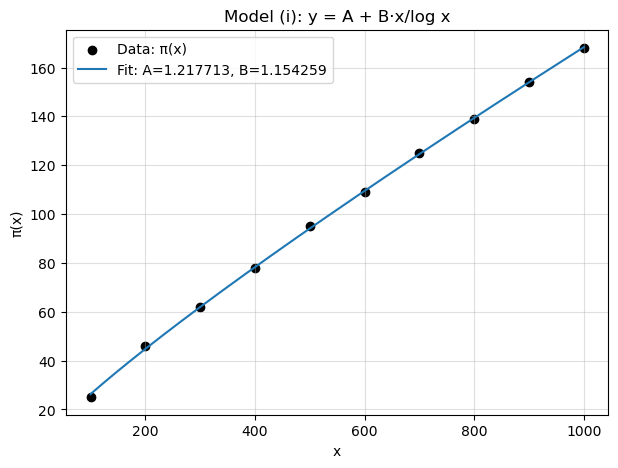

In [42]:
# Plot for Model (i)
import matplotlib.pyplot as plt
xplot = np.linspace(min(x), max(x), 500)
yhat1 = A1 + B1*(xplot/np.log(xplot))
plt.figure(figsize=(7,5))
plt.scatter(x, y, color='black', label='Data: π(x)')
plt.plot(xplot, yhat1, color='tab:blue', label=f'Fit: A={A1:.6f}, B={B1:.6f}')
plt.xlabel('x')
plt.ylabel('π(x)')
plt.title('Model (i): y = A + B·x/log x')
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()


## 2. Fit <font size="5">  $y = \frac{x}{A \log x + B}$ </font> for $\pi(x)$ by taking data of $\pi(x)$ for $x = 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000$. Predict $\pi(10^{10})$ using the model.

In [43]:
import numpy as np

def legendre_fit_linearized(xs, pis):
    """
    Fit A, B in x/pi(x) ≈ A ln x + B by OLS on (ln x, x/pi(x)),
    using the explicit normal-equation solution:
        beta = (X^T X)^(-1) (X^T y).
    
    Also computes:
      - least-squares error (RSS) in the linearized space y vs A ln x + B,
      - actual errors for the prime counting function on the same x:
          abs_err[i] = pi_hat(x_i) - pi(x_i)
          rel_err[i] = abs_err[i] / pi(x_i)

    Parameters
    ----------
    xs : array-like
        x values (e.g., [10, 100, 1000, 10000]).
    pis : array-like
        corresponding pi(x) values (e.g., [4, 25, 168, 1229]).

    Returns
    -------
    A : float
    B : float
    ls_rss : float
        Residual sum of squares in the linearized fit (y vs A ln x + B).
    pi_abs_err : np.ndarray
        Absolute errors for pi(x): pi_hat(x) - pi_true(x), for the filtered points.
    pi_rel_err : np.ndarray
        Relative errors for pi(x): (pi_hat - pi_true) / pi_true, for the filtered points.

    Notes
    -----
    - Only points with x >= 3 and pi(x) > 0 are used (to avoid log/division issues).
    - The order of error arrays corresponds to the filtered xs.
    - For numerical robustness, QR/SVD or `np.linalg.solve` are preferred in general,
      but here we use the explicit inverse as requested.
    """
    # Convert inputs to 1D float arrays (so Python lists work too)
    xs = np.asarray(xs, dtype=float).ravel()
    pis = np.asarray(pis, dtype=float).ravel()

    if xs.shape != pis.shape:
        raise ValueError(f"xs and pis must have the same shape; got {xs.shape} vs {pis.shape}")

    # Filter valid points
    mask = (xs >= 3) & (pis > 0)
    if mask.sum() < 2:
        raise ValueError("Need at least two valid points with x >= 3 and pi(x) > 0.")

    x = xs[mask]
    pi_true = pis[mask]
    t = np.log(x)
    y = x / pi_true

    # Design matrix: columns [ln x, 1]
    X = np.column_stack([t, np.ones_like(t)])

    # Explicit normal-equation solution: beta = (X^T X)^(-1) (X^T y)
    XtX = X.T @ X
    Xty = X.T @ y

    # Optional: warn if ill-conditioned (we proceed with inverse as requested)
    cond = np.linalg.cond(XtX)
    if not np.isfinite(cond):
        raise np.linalg.LinAlgError("X^T X is singular or not finite.")
    # Proceed with explicit inverse
    beta = np.linalg.inv(XtX) @ Xty

    A, B = float(beta[0]), float(beta[1])

    # Least-squares error (RSS) in the linearized space
    y_hat = X @ beta
    resid = y - y_hat
    ls_rss = float(np.sum(resid**2))

    # Actual errors for pi(x): compare pi_hat(x) vs pi_true(x)
    denom = A * t + B
    pi_hat = x / denom
    pi_abs_err = pi_hat - pi_true
    actual_error = float(np.sum(pi_abs_err**2))
    

    return A, B, ls_rss, actual_error

In [44]:
xs, pis = prime_pi_data_range(100,1000,100)  
print(xs)
print(pis)

A, B, ls_rss, actual_error = legendre_fit_linearized(xs, pis)
print("A=",A," B=",B)
print("Least squares error: ",ls_rss)
print("Actual error: ",actual_error)

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
[25, 46, 62, 78, 95, 109, 125, 139, 154, 168]
A= 0.8865424555503552  B= -0.19830734380406057
Least squares error:  0.04180636276582439
Actual error:  5.351592972633165


In [45]:
# Example prediction at x = 10^10
x_new = 10**10
t_new = np.log(x_new)
y_pred = A * t_new + B
pi_x_pred = x_new/y_pred
print(f"Prediction: pi({x_new}) ≈ {pi_x_pred:.2f}")
print("Actual Correct Value of PrimePi(10^10): ",455052511)

Prediction: pi(10000000000) ≈ 494680035.76
Actual Correct Value of PrimePi(10^10):  455052511


## 3. Legendre (Mathematician, 1752 AD - 1833 AD; no computers during the period) gave $A = 1$, $B = -1.08366$ for the model <font size="5">  $y = \frac{x}{A \log x + B}$ </font>. 

## Fit the model <font size="5">  $y = \frac{x}{A \log x + B}$ </font> with suitable data/techniques such that you get the values of $A$ and $B$ as close as possible to the values given by Legendre. Also, predict $\pi(10^{10})$ using your model.

In [612]:
# More detailed data with intermediate values and known pi(x) from tables
x1,p1=prime_pi_data_range(10,10**6,6000)
x2,p2=prime_pi_data_range(1000000,10**7,30)

xf=x1+x2
pf=p1+p2

In [613]:
A, B, ls_rss, actual_error = legendre_fit_linearized(xf, pf)
print("A=",A," B=",B)
print("Least squares error: ",ls_rss)
print("Actual error: ",actual_error)

A= 1.003321860515257  B= -1.1268464408749423
Least squares error:  2.3434873904969953
Actual error:  276229557.663997


In [614]:
x_new = 10**10
t_new = np.log(x_new)
y_pred = A * t_new + B
pi_x_pred = x_new/y_pred
print(f"Prediction: pi({x_new}) ≈ {pi_x_pred:.2f}")
print("Actual Correct Value of PrimePi(10^10): ",455052511)
print(pi_x_pred-455052511)

Prediction: pi(10000000000) ≈ 455052359.00
Actual Correct Value of PrimePi(10^10):  455052511
-151.99824798107147
